In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import pickle

import numpy as np
from matplotlib.colors import LogNorm
from fluxes import power_law
from mephisto import plot_mephistogram
from settings import *


from daemonflux import Flux
from scipy.interpolate import RegularGridInterpolator
from settings import interpolation_method
from aeff_calculations import (
    setup_aeff_grid,
    aeff_rotation,
)
import settings as st
from mephisto import Mephistogram

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


# daemonflux

In [3]:
fl = Flux(location="IceCube", use_calibration=True, debug=1)

print(fl.zenith_angles)
egrid = np.logspace(0, 9)


['0.0000', '18.1949', '25.8419', '31.7883', '36.8699', '41.4096', '45.5730', '49.4584', '53.1301', '56.6330', '60.0000', '63.2563', '66.4218', '69.5127', '72.5424', '75.5225', '78.4630', '81.3731', '84.2608', '87.1340', '90.0000', '92.8660', '95.7392', '98.6269', '101.5370', '104.4775', '107.4576', '110.4873', '113.5782', '116.7437', '120.0000', '123.3670', '126.8699', '130.5416', '134.4270', '138.5904', '143.1301', '148.2117', '154.1581', '161.8051', '180.0000']


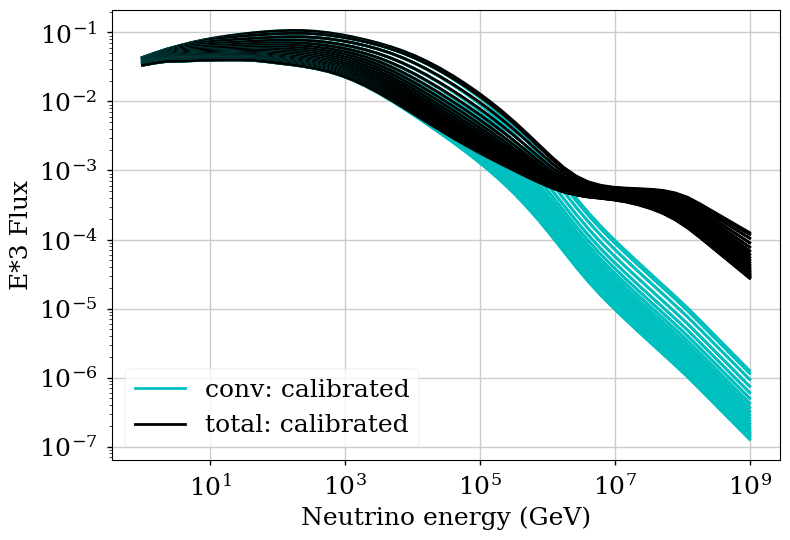

In [4]:

plt.figure()
for ii, z in enumerate(fl.zenith_angles):
    plt.loglog(
        egrid,
        fl.flux(egrid, z, "numuflux"),
        color="c",
        label="conv: calibrated" if ii == 0 else None,
    )
    plt.loglog(
        egrid,
        fl.flux(egrid, z, "total_numuflux"),
        color="k",
        label="total: calibrated" if ii == 0 else None,
    )
if False:
    plt.loglog(
        egrid,
        fl.flux(egrid, "average", "numuflux"),
        color="blue",
        ls="--",
        label="conv: calibrated" if ii == 0 else None,
    )
    plt.loglog(
        egrid,
        fl.flux(egrid, "average", "total_numuflux"),
        color="gray",
        ls="--",
        label="total: calibrated" if ii == 0 else None,
    )
plt.xlabel("Neutrino energy (GeV)")
plt.ylabel("E*3 Flux")
plt.legend()
plt.tight_layout()

In [5]:
egrid

array([1.00000000e+00, 1.52641797e+00, 2.32995181e+00, 3.55648031e+00,
       5.42867544e+00, 8.28642773e+00, 1.26485522e+01, 1.93069773e+01,
       2.94705170e+01, 4.49843267e+01, 6.86648845e+01, 1.04811313e+02,
       1.59985872e+02, 2.44205309e+02, 3.72759372e+02, 5.68986603e+02,
       8.68511374e+02, 1.32571137e+03, 2.02358965e+03, 3.08884360e+03,
       4.71486636e+03, 7.19685673e+03, 1.09854114e+04, 1.67683294e+04,
       2.55954792e+04, 3.90693994e+04, 5.96362332e+04, 9.10298178e+04,
       1.38949549e+05, 2.12095089e+05, 3.23745754e+05, 4.94171336e+05,
       7.54312006e+05, 1.15139540e+06, 1.75751062e+06, 2.68269580e+06,
       4.09491506e+06, 6.25055193e+06, 9.54095476e+06, 1.45634848e+07,
       2.22299648e+07, 3.39322177e+07, 5.17947468e+07, 7.90604321e+07,
       1.20679264e+08, 1.84206997e+08, 2.81176870e+08, 4.29193426e+08,
       6.55128557e+08, 1.00000000e+09])

In [54]:
flux_grid = np.zeros((len(fl.zenith_angles), len(egrid)))
zeniths = np.array(fl.zenith_angles, dtype=float)
for ii, zz in enumerate(fl.zenith_angles):
    flux_grid[ii] = fl.flux(egrid, zz, "total_numuflux")  / (egrid**3)
flux_grid = flux_grid.T
savepath = join(BASEPATH, "resources", "MCEq_daemonflux.pckl")
with open(savepath, "wb") as f:
    pickle.dump(((egrid, zeniths), flux_grid), f)

In [6]:
with open(join(st.BASEPATH, "resources/MCEq_daemonflux.pckl"), "rb") as f:
    (e_grid, zen), bckg_flux = pickle.load(f)


In [7]:
np.shape(e_grid), np.shape(zen), np.shape(bckg_flux)

((50,), (41,), (50, 41))

In [8]:
e_grid

array([1.00000000e+00, 1.52641797e+00, 2.32995181e+00, 3.55648031e+00,
       5.42867544e+00, 8.28642773e+00, 1.26485522e+01, 1.93069773e+01,
       2.94705170e+01, 4.49843267e+01, 6.86648845e+01, 1.04811313e+02,
       1.59985872e+02, 2.44205309e+02, 3.72759372e+02, 5.68986603e+02,
       8.68511374e+02, 1.32571137e+03, 2.02358965e+03, 3.08884360e+03,
       4.71486636e+03, 7.19685673e+03, 1.09854114e+04, 1.67683294e+04,
       2.55954792e+04, 3.90693994e+04, 5.96362332e+04, 9.10298178e+04,
       1.38949549e+05, 2.12095089e+05, 3.23745754e+05, 4.94171336e+05,
       7.54312006e+05, 1.15139540e+06, 1.75751062e+06, 2.68269580e+06,
       4.09491506e+06, 6.25055193e+06, 9.54095476e+06, 1.45634848e+07,
       2.22299648e+07, 3.39322177e+07, 5.17947468e+07, 7.90604321e+07,
       1.20679264e+08, 1.84206997e+08, 2.81176870e+08, 4.29193426e+08,
       6.55128557e+08, 1.00000000e+09])

In [59]:
# set up the interpolation function
sindec_mids_bg = -np.cos(np.deg2rad(zen))
rgi = RegularGridInterpolator(
    (e_grid, sindec_mids_bg),
    np.log(bckg_flux ),
    method=interpolation_method,
)

# finer interpolation for further steps
ss, em = np.meshgrid(st.sindec_mids, st.emids)
numu_bg = np.exp(rgi((em, ss)))

grid2d, eq_coords = setup_aeff_grid(
    numu_bg, st.sindec_mids, st.ra_mids, st.ra_width, log_int=True
)

# loop over detectors and rotate the local background flux to equatorial coordinates
# i.e. calculate the average bg flux per day in equatorial sin(dec)
bg_i = {}
det_list = ["IceCube", "P-ONE", "KM3NeT", "Baikal-GVD"]
for k in det_list:
    bg_i[k] = Mephistogram(
        aeff_rotation(
            st.poles[k]["lat"],
            st.poles[k]["lon"],
            eq_coords,
            grid2d,
            st.ra_width,
            log_aeff=True,
        ).T,
        (st.sindec_bins, st.logE_bins),
        ("sin(dec)", "log(E/GeV)"),
        make_hist=False,
    )

# check if histos are matching
#print(bg_i["IceCube"].match(aeff_2d["IceCube"], verbose=True))

with open(join(st.LOCALPATH, "atmospheric_background_daemonflux_MH.pckl"), "wb") as f:
    pickle.dump(bg_i, f)

# comparison

In [20]:
with open(join(BASEPATH, "resources/MCEq_flux.pckl"), "rb") as f:
    (e_grid, zen), bckg_flux = pickle.load(f)
# set up the interpolation function
sindec_mids_bg_old = -np.cos(np.deg2rad(zen))
rgi_old = RegularGridInterpolator(
    (e_grid, sindec_mids_bg_old),
    np.log(bckg_flux["numu_total"]),
    method=interpolation_method,
)

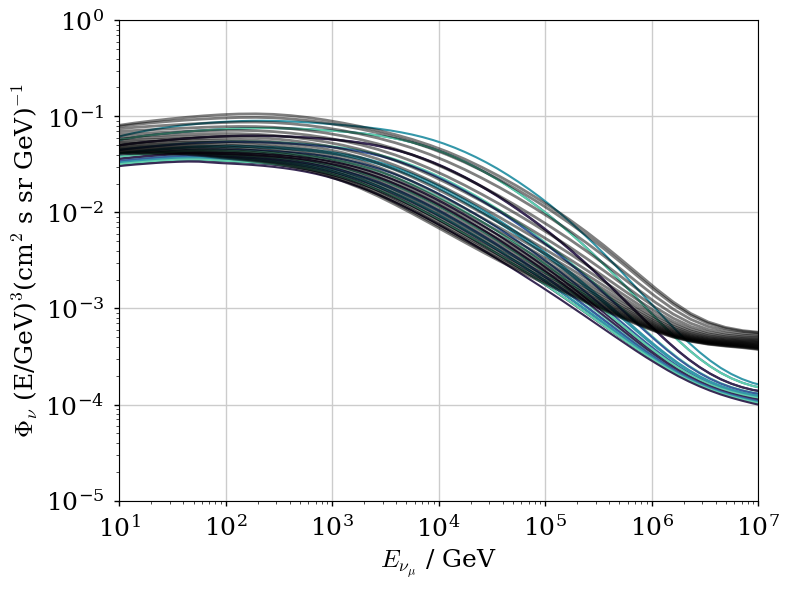

In [23]:
spec = 3
fig, ax = plt.subplots(figsize=(8, 6))
for ti, _ in enumerate(zen):
    for i, (pref, lab) in enumerate([("numu_", r"\nu_\mu")]):

        p0 = ax.loglog(
            e_grid,
            e_grid ** (spec) * bckg_flux[pref + "total"][:, ti],
            ls="solid",
            lw=1.5,
        )
for ii, z in enumerate(fl.zenith_angles):

    plt.loglog(
        egrid,
        fl.flux(egrid, z, "total_numuflux"),
        color="k", alpha=0.5,
        label="total: calibrated" if ii == 0 else None,
    )
ax.set_xlim(10, 1e7)
ax.set_ylim(1e-5, 1)
ax.set_xlabel(r"$E_{{{0}}}$ / GeV".format(lab))
ax.set_ylabel(
    r"$\Phi_{\nu}$ (E/GeV)$^{" + str(spec) + " }$" + "(cm$^{2}$ s sr GeV)$^{-1}$"
)
fig.tight_layout()

# Preparations

In [3]:
# need to run once in the beginning to prepare all ingredients for the analysis
# this might take several minutes

# run these only if you haven't done so before
# calculate the atmospheric neutrino background using MCEq (IceCube-centric)
# %run ../../core/atmospheric_background.py

# run these every time there are updates to resolution, binning, or mephistograms
# load and prepare the energy and angular resolutions
%run ../../core/resolution.py

# gather all ingredients and save them as unified 'mephistogram' data structure
%run ../../core/prepare_histograms.py

file exists: /home/lisajsch/repos/Plenum/local/e_psf_grid_psimax-3_bins-25.pckl
file exists: /home/lisajsch/repos/Plenum/local/energy_smearing_2D_step-0.1.pckl
140 log_10(energy) bins
100 declination bins
140 log_10(energy) bins
100 declination bins
Elementary arithmetic possible.
True


# Default binning

In [3]:
print(len(logE_bins), np.min(logE_bins), np.max(logE_bins))
print(len(logE_reco_bins), np.min(logE_reco_bins), np.max(logE_reco_bins))
print(len(sindec_bins), np.min(sindec_bins), np.max(sindec_bins))


141 2.0 8.999999999999975
140 2.0 8.949999999999974
101 -1.0 1.0


# Background

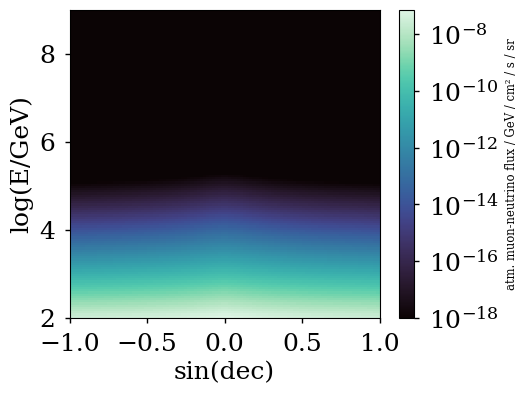

In [8]:
# MCEQ: atmospheric flux on muon neutrinos (see also 'background_flux.ipynb')
with open(join(LOCALPATH, "atmospheric_background_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)

# visualization of bckg flux
plot_mephistogram(bckg_histo, norm=LogNorm(vmin=1E-18))
cb = plt.gca().collections[0].colorbar
cb.set_label("atm. muon-neutrino flux / GeV / cm² / s / sr", fontsize="small")


# Load underlying mceq flux

In [3]:
# MCEQ atmospheric background
with open(join(BASEPATH, "resources/MCEq_flux.pckl"), "rb") as f:
    (e_grid, zen), bckg_flux = pickle.load(f)


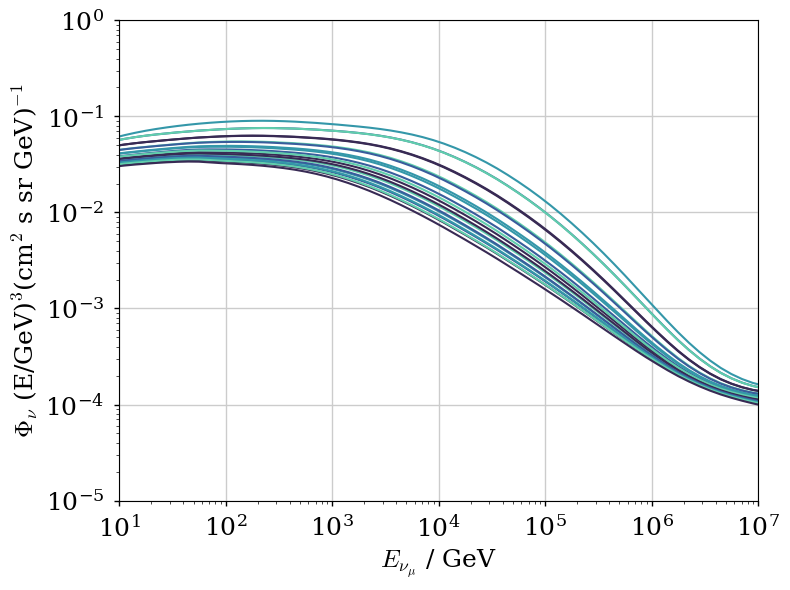

In [11]:
spec = 3
fig, ax = plt.subplots(figsize=(8, 6))
for ti, _ in enumerate(zen):
    for i, (pref, lab) in enumerate([("numu_", r"\nu_\mu")]):

        p0 = ax.loglog(
            e_grid,
            e_grid ** (spec) * bckg_flux[pref + "total"][:, ti],
            ls="solid",
            lw=1.5,
        )

ax.set_xlim(10, 1e7)
ax.set_ylim(1e-5, 1)
ax.set_xlabel(r"$E_{{{0}}}$ / GeV".format(lab))
ax.set_ylabel(
    r"$\Phi_{\nu}$ (E/GeV)$^{" + str(spec) + " }$" + "(cm$^{2}$ s sr GeV)$^{-1}$"
)
fig.tight_layout()


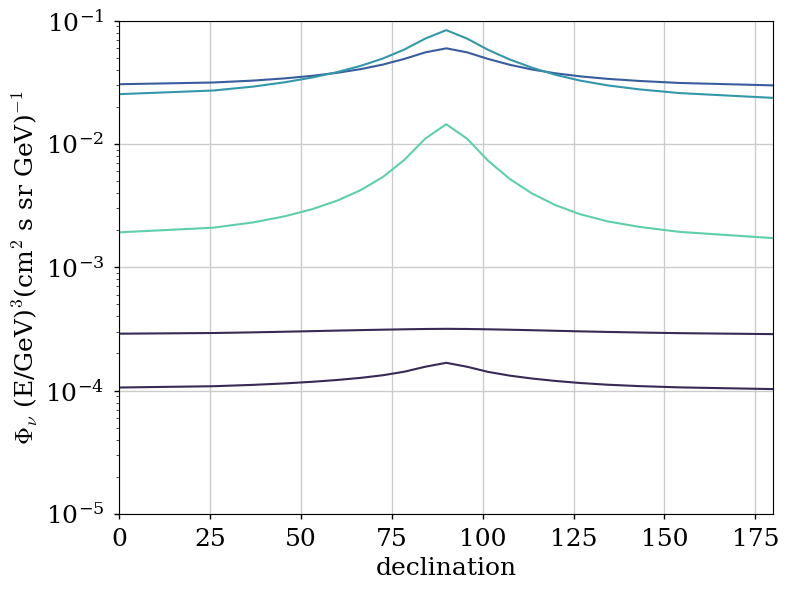

In [16]:
spec = 3
fig, ax = plt.subplots(figsize=(8, 6))
for ei, cur_e in enumerate(e_grid):
    if ei%20!=0: continue
    for i, (pref, lab) in enumerate([("numu_", r"\nu_\mu")]):

        p0 = ax.plot(
            zen,
            cur_e ** (spec) * bckg_flux[pref + "total"][ei],
            ls="solid",
            lw=1.5,
        )

ax.set_xlim(0, 180)
ax.set_yscale("log")
ax.set_ylim(1e-5, 0.1)
ax.set_xlabel("declination")
ax.set_ylabel(
    r"$\Phi_{\nu}$ (E/GeV)$^{" + str(spec) + " }$" + "(cm$^{2}$ s sr GeV)$^{-1}$"
)
fig.tight_layout()


## With astro flux, as comparison

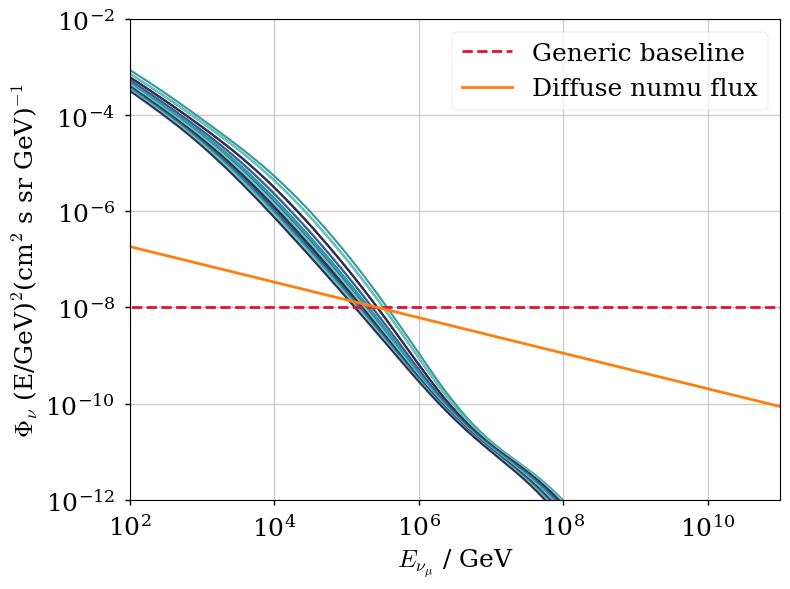

In [8]:
spec = 2
fig, ax = plt.subplots(figsize=(8, 6))
for ti, ang in enumerate(zen):
    for i, (pref, lab) in enumerate([("numu_", r"\nu_\mu")]):
        p0 = ax.loglog(
            e_grid,
            e_grid ** (spec) * bckg_flux[pref + "total"][:, ti],
            ls="solid",
            lw=1.5,
        )
ax.loglog(
    e_grid,
    power_law(e_grid, 1e5, 2, 1e-18) * e_grid ** (spec),
    label="Generic baseline",
    color="crimson",
    ls="--",
)  # generic baseline spectrum ~E^-2
ax.loglog(
    e_grid,
    power_law(e_grid, 1e5, GAMMA_ASTRO, PHI_ASTRO) * e_grid ** (spec),
    label="Diffuse numu flux",
    color="tab:orange",
)  # best-fit numu
ax.legend()
ax.set_xlim(1e2, 1e11)
ax.set_ylim(1e-12, 1e-2)
ax.set_xlabel(r"$E_{{{0}}}$ / GeV".format(lab))
ax.set_ylabel(
    r"$\Phi_{\nu}$ (E/GeV)$^{" + str(spec) + " }$" + "(cm$^{2}$ s sr GeV)$^{-1}$"
)
fig.tight_layout()
